## Options structural break detection with N-beats

### We has found 14w train with 12w IQR outlier provide the best TPR. We will test on other period like 2013-2015

### Equity options

In [1]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint
import pickle

In [2]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import NBeats, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, MAPE, MASE, SMAPE

# Load TensorBoard notebook extension
%load_ext tensorboard

# allow Matplotlib plots display within notebook 
%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from time_series_utils import get_nth_train_split

Importing plotly failed. Interactive plots will not work.


In [5]:
from time_series_nbeats_utils import preprocess_nbeats, nbeats_modeler, compute_mape,\
                        return_nbeats_predictions, train_n_weeks_for_3years

## Cboe Options Historical Volume and Put/Call Ratios

### Equity options 

In [6]:
from datetime import datetime
dateparser = lambda x: datetime.strptime(x, '%m/%d/%Y')

In [7]:
TRAIN_WEEKS = 14

In [8]:
pickle_dir = "../results_pickle_format"

In [9]:
with open(f'{pickle_dir}/IDX_options.pkl', 'rb') as f:
    df1_eqt = pickle.load(f)

We need to add the group column. set to same group id.

In [10]:
df1_eqt.head()

PutCall_Ratio_Total
Date                           
2006-11-06            573452.46
2006-11-07            631694.96
2006-11-08            532944.72
2006-11-09            630284.04
2006-11-10            437933.40

In [11]:
df1_eqt = preprocess_nbeats(df1_eqt)

In [12]:
df1_eqt1 = df1_eqt['2013-01-01':'2017-01-01']
df1_eqt1

PutCall_Ratio_Total  group  time_idx
Date                                            
2013-01-01         2.094819e+06      1      2248
2013-01-02         2.547660e+06      1      2249
2013-01-03         1.847272e+06      1      2250
2013-01-04         1.136298e+06      1      2251
2013-01-05         1.309932e+06      1      2252
...                         ...    ...       ...
2016-12-28         1.180727e+06      1      3705
2016-12-29         1.305653e+06      1      3706
2016-12-30         1.673966e+06      1      3707
2016-12-31         1.758864e+06      1      3708
2017-01-01         1.843762e+06      1      3709

[1462 rows x 3 columns]

<AxesSubplot:xlabel='Date'>

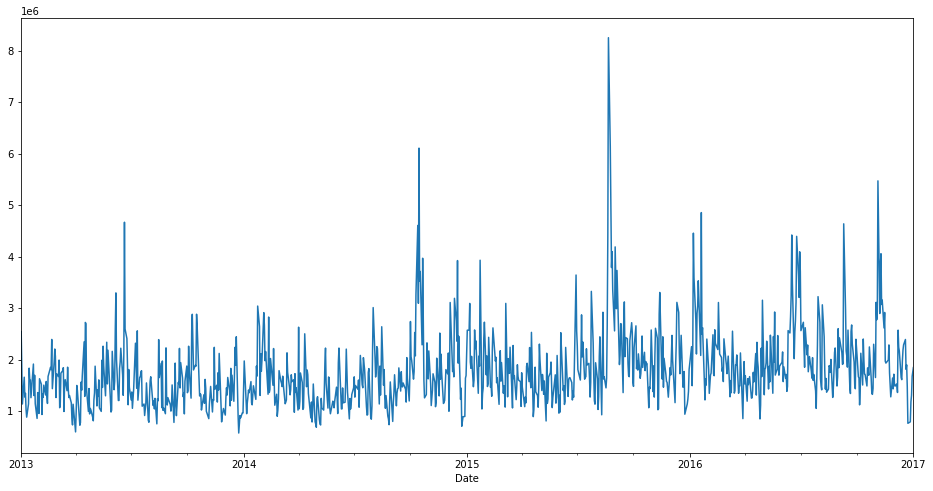

In [13]:
df1_eqt1['PutCall_Ratio_Total'].plot(figsize=(16,8))

Preprocess data for N-beats 

In [14]:
df1_eqt1.describe()

PutCall_Ratio_Total   group    time_idx
count         1.462000e+03  1462.0  1462.00000
mean          1.782947e+06     1.0  2978.50000
std           7.235236e+05     0.0   422.18736
min           5.722336e+05     1.0  2248.00000
25%           1.319485e+06     1.0  2613.25000
50%           1.657098e+06     1.0  2978.50000
75%           2.055819e+06     1.0  3343.75000
max           8.253648e+06     1.0  3709.00000

In [15]:
training_df, validation_df, test_df = get_nth_train_split(df1_eqt1, 155, train_week_len=TRAIN_WEEKS)

In [16]:
model, trainer, train_dataloader, val_dataloader, test_dataloader = nbeats_modeler(training_df, validation_df, test_df, max_encoder_length=(TRAIN_WEEKS-1)*7)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
len(training_df)

98

In [18]:
training_df.columns

Index(['PutCall_Ratio_Total', 'group', 'time_idx'], dtype='object')

In [19]:
model

NBeats(
  (loss): MAPE()
  (logging_metrics): ModuleList(
    (0): MAPE()
  )
  (net_blocks): ModuleList(
    (0): NBEATSTrendBlock(
      (fc): Sequential(
        (0): Linear(in_features=91, out_features=32, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (3): ReLU()
        (4): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (5): ReLU()
      )
      (theta_f_fc): Linear(in_features=32, out_features=3, bias=False)
      (theta_b_fc): Linear(in_features=32, out_features=3, bias=False)
    )
    (1): NBEATSSeasonalBlock(
      (fc): Sequential(
        (0): Linear(in_features=91, out_features=512, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=512, out_features=512, bias=

In [19]:
%tensorboard --logdir training_logs

Reusing TensorBoard on port 6006 (pid 31340), started 12 days, 8:29:10 ago. (Use '!kill 31340' to kill it.)

In [20]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MAPE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 581 K 
-----------------------------------------------
581 K     Trainable params
0         Non-trainable params
581 K     Total params
2.325     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

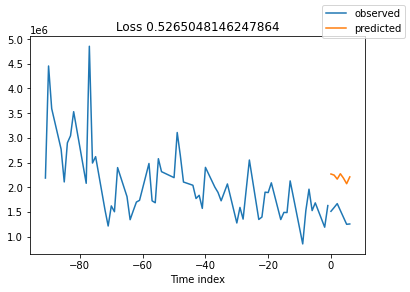

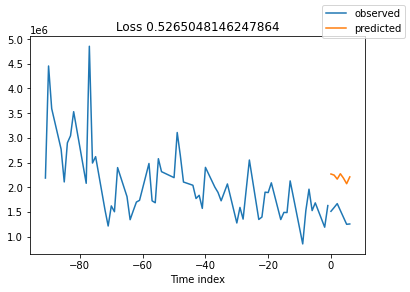

In [21]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

raw_predictions, x = best_model.predict(test_dataloader, mode="raw", return_x=True)

best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)

In [22]:
%%capture

mape_list, pred_df = train_n_weeks_for_3years(df1=df1_eqt1, train_weeks=TRAIN_WEEKS)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LR finder stopped early after 50 steps due to diverging loss.
Restoring states from the checkpoint path at C:\Users\wismi\workspace\final_project\structural_break_down\.lr_find_844c550b-82b7-4b83-af1c-37e1c3ae7f93.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MAPE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 581 K 
-----------------------------------------------
581 K     Trainable params
0         Non-trainable params
581 K     Total params
2.325     Total estimated model params size (MB)
Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU 

In [23]:
mape_list

[(0.3481002483697728,
  (Timestamp('2013-04-17 00:00:00', freq='D'),
   Timestamp('2013-04-23 00:00:00', freq='D'))),
 (0.3893734336145521,
  (Timestamp('2013-04-24 00:00:00', freq='D'),
   Timestamp('2013-04-30 00:00:00', freq='D'))),
 (0.1208356359837469,
  (Timestamp('2013-05-01 00:00:00', freq='D'),
   Timestamp('2013-05-07 00:00:00', freq='D'))),
 (0.23224096362830451,
  (Timestamp('2013-05-08 00:00:00', freq='D'),
   Timestamp('2013-05-14 00:00:00', freq='D'))),
 (0.17458567393334365,
  (Timestamp('2013-05-15 00:00:00', freq='D'),
   Timestamp('2013-05-21 00:00:00', freq='D'))),
 (0.22107445901499695,
  (Timestamp('2013-05-22 00:00:00', freq='D'),
   Timestamp('2013-05-28 00:00:00', freq='D'))),
 (0.1934931715698174,
  (Timestamp('2013-05-29 00:00:00', freq='D'),
   Timestamp('2013-06-04 00:00:00', freq='D'))),
 (0.37847067208232205,
  (Timestamp('2013-06-05 00:00:00', freq='D'),
   Timestamp('2013-06-11 00:00:00', freq='D'))),
 (0.2388795229462847,
  (Timestamp('2013-06-12 00:00

In [24]:
sum(map(lambda x: x[0], mape_list))/len(mape_list)

0.2688216465398083

In [25]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU (UUID: GPU-96f000f0-5638-0a47-31c8-35ed21bbb409)


In [26]:
import pickle

with open(f"{pickle_dir}/n_beats_interval_{TRAIN_WEEKS}w_IDX_2013-2015.pkl", "wb") as f:
    pickle.dump(mape_list, f)

In [27]:
with open(f'{pickle_dir}/n_beats_interval_{TRAIN_WEEKS}w_IDX_pred_2013-2015.pkl', 'wb') as f:
    pickle.dump(pred_df, f)